<a href="https://colab.research.google.com/github/AlexSacMorane/LGCIV2041/blob/main/Frame.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Application of the displacement method to solve frame structures

This code was originally prepared for the course LGCIV1023 (Stabilité des Constructions), on Decembre 3 2019

Igor Bouckaert, João Pacheco de Almeida, Martin Steinmetz

Adapted for the course "Nonlinear Response Analysis", Rose, Pavia, Italy, in May 2021

Adapted for the course LGCIV2041 (Numerical Analysis of Civil Engineering Structures) by João Pacheco de Almeida on February 1 2023


# 0: INTRODUCTION

This code written for Python / Google Colaboraty / Jupyter notebook aims to go step by step through a numerical solution of a frame structure with the stiffness or displacement method.

To do this, simply run each cell of code one after the other and check what each one does.

**IMPORTANT**

Before starting, it is also necessary to run all the cells signaled with the DEFINITIONS section within this section header, which define the different functions and libraries that will be used in the rest of the code.


## DEFINITIONS
Import the required libraries

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv

Display of the element undeformed configuration based on the connectivity (incidence) matrix

In [32]:
def PlotUndeformed(coord, connect) :

    for i in range(len(connect)) :
        plt.plot( [coord[0][connect[i][0]] , coord[0][connect[i][1]]] ,
                [coord[1][connect[i][0]] , coord[1][connect[i][1]]] ,
                '#000000' )

    plt.plot(Coord[0], Coord[1], 'ro')

    for i in range(len(coord[1])) :
        plt.annotate(str(i), (coord[0][i], coord[1][i]))

    plt.show()

Display of the deformed configuration of the element

In [33]:
def PlotDeformed(coord, connect, displ, scale) :

    coord_def = coord + displ * scale

    for i in range(len(connect)) :
        plt.plot( [coord[0][connect[i][0]] , coord[0][connect[i][1]]] ,
                [coord[1][connect[i][0]] , coord[1][connect[i][1]]] ,
                '#000000' )
        plt.plot([coord_def[0][connect[i][0]] , coord_def[0][connect[i][1]]] ,
                [coord_def[1][connect[i][0]] , coord_def[1][connect[i][1]]] ,
                'r-', linewidth=0.5)

    plt.plot(coord[0], coord[1], 'ro')

    for i in range(len(coord[1])) :
        plt.annotate(str(i), (coord[0][i], coord[1][i]))

    plt.show()

Display of the shear forces

In [34]:
def PlotShear(coord, connect, Shear) :

    for i in range(len(connect)) :
        plt.plot( [coord[0][connect[i][0]] , coord[0][connect[i][1]]] ,
                [coord[1][connect[i][0]] , coord[1][connect[i][1]]] ,
                '#000000' )

    plt.plot(coord[0], coord[1], 'ro')

    for i in range(len(connect)) :
        plt.plot( [coord[0][connect[i][0]], coord[0][connect[i][1]]],
                [coord[1][connect[i][0]]+ Shear[i][0], coord[1][connect[i][1]]+ Shear[i][1]] ,
                'g' )
        if not (i == len(connect) or i == 0) :
            plt.plot([coord[0][connect[i][0]], coord[0][connect[i][0]]],
                [coord[1][connect[i][0]]+ Shear[i-1][1], coord[1][connect[i][1]]+ Shear[i][0]] ,
                'g' )
        elif i == 0 :
            plt.plot([coord[0][connect[i][0]], coord[0][connect[i][0]]],
                [coord[1][connect[i][0]], coord[1][connect[i][1]]+ Shear[i][0]] ,
                'g' )
        if i == len(connect) - 1 :
            plt.plot([coord[0][connect[i][1]], coord[0][connect[i][1]]],
                [coord[1][connect[i][1]]+ Shear[i][1], coord[1][connect[i][1]]],
                'g' )

def PlotBending(coord, connect, Bending, Shear) :

    for i in range(len(connect)) :
        plt.plot( [coord[0][connect[i][0]] , coord[0][connect[i][1]]] ,
                [coord[1][connect[i][0]] , coord[1][connect[i][1]]] ,
                '#000000' )

    plt.plot(coord[0], coord[1], 'ro')
    Starting_point = 0

    for i in range(len(connect)) :
        L = abs(coord[0][connect[i][1]] - coord[0][connect[i][0]])
        x = np.linspace(0, L)
        a =  - (Shear[i][1] - Shear[i][0]) / (2*L)
        b =  - Shear[i][0]
        c = Bending[i][0]
        M = a * x ** 2 + b * x + c

        plt.plot(x+Starting_point,M,'r')

        Starting_point += L

        if not (i == len(connect) or i == 0) :
            plt.plot([coord[0][connect[i][0]], coord[0][connect[i][0]]],
                [coord[1][connect[i][0]]+ Bending[i-1][1], coord[1][connect[i][1]]+ Bending[i][0]] ,
                'r' )
        elif i == 0 :
            plt.plot([coord[0][connect[i][0]], coord[0][connect[i][0]]],
                [coord[1][connect[i][0]], coord[1][connect[i][1]]+ Bending[i][0]] ,
                'r' )
        if i == len(connect) - 1 :
            plt.plot([coord[0][connect[i][1]], coord[0][connect[i][1]]],
                [coord[1][connect[i][1]]+ Bending[i][1], coord[1][connect[i][1]]],
                'r' )

# 1: Input

All parameters that need to be set by the user are listed in this section with # USER

## Bridge

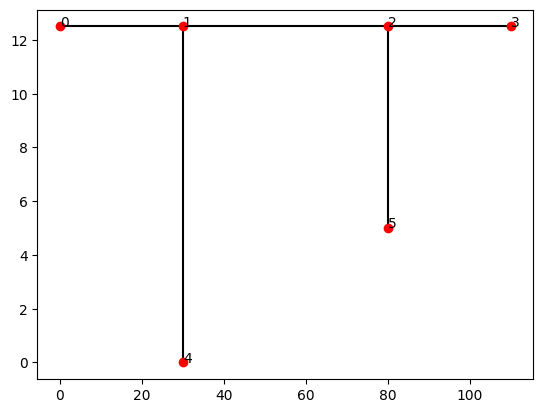

In [35]:
# Material
E = 35e9 # [N/m^2]
A = 50e-4 # [m^2]
I = 15000e-8 # [m^4]
AE_Elem = np.array([A*E, A*E, A*E, A*E, A*E])
EI_Elem = np.array([E*I, E*I, E*I, E*I, E*I])

# Coordinates of the nodes: x in the first line and y in the second line, in [m].
Coord = np.array([[0, 30, 80, 110, 30, 80],
                  [12.5, 12.5, 12.5, 12.5, 0, 5]])

# Connections between the nodes
Connect = np.array([[0, 1],
                    [1, 2],
                    [2, 3],
                    [4, 1],
                    [5, 2]])

PlotUndeformed(Coord, Connect) # Display of nodes

## Total number of degrees of freedom + numbering

In [36]:
No_Ddl = len(Coord[1])*3  # 3 DoF per node
Num_Ddl = np.arange(No_Ddl) # Indexing starts at 0 in Python
print('The structure has ' + str(No_Ddl) + ' degrees of freedom')

#Defining the type of Element : 6 or 5 DoFs (5 - to complete in Assignment)
Elem_Types = np.array([6, 6, 6, 6, 6])

# Total number of elements
No_Elem = len(Connect)
print("The structure is composed of " + str(No_Elem) + " elements.")

# Fixed degrees of freedom
Fixed_DoF = np.array([1, 10, 12, 13, 14, 15, 16, 17])

# Free degrees of freedom
Free_DoF = np.delete(Num_Ddl, Fixed_DoF)

print('Free DoF',Free_DoF)

The structure has 18 degrees of freedom
The structure is composed of 5 elements.
Free DoF [ 0  2  3  4  5  6  7  8  9 11]


## Nodal loads

In [37]:
# Initialization
P = np.zeros(No_Ddl)

# Forces applied to degrees of freedom
# in [N] and [m]
P_f = np.array([0, 0, -300e3, 0, 0, -150e3, 0, 0, 0, 0])

# Building other vectors:
P[Free_DoF] = P_f

## Other

In [38]:
# Variable used to magnify the plot of deformed shape, if needed
Scale = 500

# 2: Computations

## Phase 1: Initialization of vectors and matrices

In [39]:
# Initialization of the vector of structural displacements
U = np.zeros(No_Ddl)
# The displacement vector corresponding to the fixed degrees of freedom is a zero vector
U_d = U[Fixed_DoF]

# Initialization of the local and global stiffness matrices of the elements, and of the structural stiffness matrix
K_str = np.zeros((No_Ddl, No_Ddl))
k_elem_loc = np.zeros((No_Elem,6,6))  # MODIFIE
k_elem_glob = np.zeros((No_Elem,6,6))

# Initialization of the matrices containing :
# 1. The length of the elements
L_Elem = np.zeros(No_Elem)
# 2. Rotation matrix for each element
r_C = np.zeros((No_Elem,6,6)) #MODIFIE
# 3. Assembly matrix
Assemblage = np.zeros((No_Elem, 6))


## Phase 2: Elements' length, rotation matrices, and assembly matrix
Loop over the elements to calculate their respective lengths, rotation matrices, and assembly matrix

In [40]:
for i in range(No_Elem) :

    # 1. Element's length
    L_x = Coord[0][Connect[i][1]] - Coord[0][Connect[i][0]]  # Length in x
    L_y = Coord[1][Connect[i][1]] - Coord[1][Connect[i][0]]  # Length in y
    L_Elem[i] = np.sqrt(L_x**2 + L_y**2)

     # 2. Rotation matrices [[cos sin 0 0],[0 0 cos sin]]
    sin = L_y / L_Elem[i] # Sine of the rotation angle of truss element i
    cos = L_x / L_Elem[i] # Cosine of the rotation angle of truss element i
    r_C[i] = np.array([[cos, sin, 0, 0, 0, 0],
                       [-sin, cos, 0, 0, 0, 0],
                       [0, 0, 1, 0, 0, 0],
                       [0, 0, 0, cos, sin, 0],
                       [0, 0, 0, -sin, cos, 0],
                       [0, 0, 0, 0, 0, 1]])  #MODIFIE

    # Auxiliary matrices for the assembly: positioning of local matrices in the global matrix
    Assemblage[i] = np.array([Connect[i][0]*3,
                              Connect[i][0]*3+1,
                              Connect[i][0]*3+2,
                              Connect[i][1]*3,
                              Connect[i][1]*3+1,
                              Connect[i][1]*3+2])
    Assemblage = Assemblage.astype(int)

## Phase 3: Computation of local stiffness matrices
Loop through the elements to calculate their respective local stiffness matrices in the local (k_loc) and global (k_glob) reference system, followed by assembly into the structural stiffness matrix
NOTE: the matrix product is written '@' in Python

In [41]:
for elem in range(No_Elem) :

    # Stiffness matrices in the local reference system, 6 DoF
    if Elem_Types[elem] == 6 :
        k_elem_loc[elem] = np.array([[AE_Elem[elem]/L_Elem[elem], 0, 0, -AE_Elem[elem]/L_Elem[elem], 0, 0],
                                     [0, 12*EI_Elem[elem]/L_Elem[elem]**3,  6*EI_Elem[elem]/L_Elem[elem]**2, 0,  -12*EI_Elem[elem]/L_Elem[elem]**3,  6*EI_Elem[elem]/L_Elem[elem]**2],
                                     [0, 6*EI_Elem[elem]/L_Elem[elem]**2,   4*EI_Elem[elem]/L_Elem[elem],   0,   -6*EI_Elem[elem]/L_Elem[elem]**2,   2*EI_Elem[elem]/L_Elem[elem]],
                                     [-AE_Elem[elem]/L_Elem[elem], 0, 0, AE_Elem[elem]/L_Elem[elem], 0, 0],
                                     [0, -12*EI_Elem[elem]/L_Elem[elem]**3, -6*EI_Elem[elem]/L_Elem[elem]**2, 0,  12*EI_Elem[elem]/L_Elem[elem]**3,   -6*EI_Elem[elem]/L_Elem[elem]**2],
                                     [0, 6*EI_Elem[elem]/L_Elem[elem]**2,   2*EI_Elem[elem]/L_Elem[elem],  0,    -6*EI_Elem[elem]/L_Elem[elem]**2,   4*EI_Elem[elem]/L_Elem[elem]]])  #MODIFIE

    # TO COMPLETE
    # Stiffness matrices in the local reference system, 5 DoF
    # elif Elem_Types[elem] == 5 :


    # Stiffness matrices in the global reference system
    k_elem_glob[elem] = np.transpose(r_C[elem]) @ k_elem_loc[elem] @ r_C[elem]

    # Assembly of the global structural stiffness matrix
    for j in range(len(k_elem_glob[elem])) :
        for k in range(len(k_elem_glob[elem])) :
            K_str[Assemblage[elem][j]][Assemblage[elem][k]] += k_elem_glob[elem][j][k]

## Phase 4: Partitioning of the stiffness matrix

In [42]:
# Sub-matrix for the free DoFs:
K_ff = K_str[Free_DoF[:,None], Free_DoF[None,:]]

# Sub-matrix for the fixed DoFs:
K_dd = K_str[Fixed_DoF[:,None], Fixed_DoF[None,:]]

# Sub-matrices K_fd et K_df:
K_fd = K_str[Free_DoF[:,None], Fixed_DoF[None,:]]
K_df = np.transpose(K_fd)


## Phase 5: Displacement's equation

Solving the displacement equation to find the value of the free degrees of freedom

In [43]:
U_f = inv(K_ff) @ (P_f - K_fd @ U_d)

# Completing the global displacement vector:
U[Free_DoF] = U_f
U[Fixed_DoF] = U_d
print('Displacement',U)

Displacement [-5.23093526e+00  0.00000000e+00 -1.70715165e-01 -5.23093526e+00
 -5.59530545e-04  3.41374377e-01 -5.17376611e+00  2.58824798e-05
  7.54506629e-01 -5.17376611e+00  0.00000000e+00 -3.77254609e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00]


## Phase 6: Reactions' equation

Solving the reactions' equation to find the unknown reactions in the structure

In [44]:
P_d = K_df @ U_f + K_dd @ U_d

# Completing the vector of nodal forces:
P[Fixed_DoF] = P_d

# Computing the structural resisting forces:
P_r = K_str @ U

## Phase 7: Computation of internal forces

In [45]:
# Initialization of vectors u_loc et p_loc

u_loc = np.zeros((No_Elem, 6))  #MODIFIE
p_loc = np.zeros((No_Elem, 6))  #MODIFIE

for i in range(No_Elem) :
    u_loc[i] = r_C[i] @ U[Assemblage[i]]
    p_loc[i] = k_elem_loc[i] @ u_loc[i]

    print('Element',i,'Internal forces',p_loc[i])

Element 0 Internal forces [ 0.00000000e+00  5.97437800e+03 -1.45519152e-11  0.00000000e+00
 -5.97437800e+03  1.79231340e+05]
Element 1 Internal forces [-200092.02676095   13807.80562956  301816.25434008  200092.02676095
  -13807.80562956  388574.02713797]
Element 2 Internal forces [     0.          13203.881102   396116.43306005      0.
 -13203.881102        0.        ]
Element 3 Internal forces [   7833.42763268  -99907.97323905 -767802.07124161   -7833.42763268
   99907.97323905 -481047.59424654]
Element 4 Internal forces [-6.03924528e+02 -3.50092027e+05 -1.84099974e+06  6.03924528e+02
  3.50092027e+05 -7.84690460e+05]


# 3: Display
Display of the internal forces per element

Axial force in element 4 = 0.6kN
Shear force in element 4 = [[-350. -350.]]kN
Bending moment in element 4 = [[-1841.   785.]]kN.m


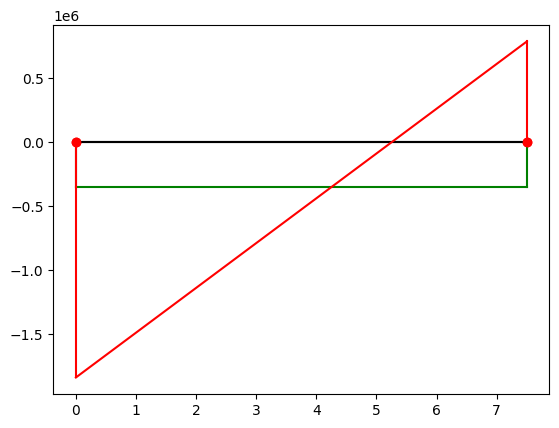

In [46]:
#Choice of the element to display

Elem_ID_to_display = 4

Shear = np.zeros((1,2))
Bending = np.zeros((1,2))

Shear[0][0] = p_loc[Elem_ID_to_display][1]
Shear[0][1] = -p_loc[Elem_ID_to_display][4]
Bending[0][0] = p_loc[Elem_ID_to_display][2]
Bending[0][1] = -p_loc[Elem_ID_to_display][5]
N = p_loc[Elem_ID_to_display][3]

# Display of axial force
print("Axial force in element {} = {}kN".format(Elem_ID_to_display, np.around(N/1000,2)))

# Display of shear force
PlotShear(np.array([[0, L_Elem[Elem_ID_to_display]],[0,0]]), np.array([[0,1]]), Shear)
print("Shear force in element {} = {}kN".format(Elem_ID_to_display, np.round(Shear/1000,0)))

# Display of bending moment
PlotBending(np.array([[0, L_Elem[Elem_ID_to_display]],[0,0]]), np.array([[0,1]]), Bending, Shear)
print("Bending moment in element {} = {}kN.m".format(Elem_ID_to_display, np.round(Bending/1000,0)))
